# Explores osm_build_network

This notebook is for snapping of substations to lines

### Jupyter notebook needs to be improved (content and structure?). 

It seems also geoplot need to be added to the environment. How to: 
- One need to deinstall the whole environment locally and install everything from scratch from the environment.yaml. Thereby the environment.yaml needs now `geoplot`.
- Subsequently, one need to test if there are any conflicts using geoplot in the other scripts (geoplot might be in conflict with other packages)

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import pandas as pd
import numpy as np
import pandas as pd
import hvplot.pandas

# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

# Africa shape data

In [2]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# africa = world.query('continent == "Africa"')
nigeriaplot = world.query('name == "Nigeria"')
# world

# Power data

In [3]:
# choose the option to get your plot
# option = 'raw'
# option = 'clean'
option = "line2network"

scenario_name = ""  # scenario name, default value is "" for tutorial or default configuration
                    # value shall be non null if a scenario name is specified under the "run" tag in the config file

scenario_subpath = scenario_name + "/" if scenario_name else ""

raw_path = "pypsa-earth/resources/" + scenario_subpath + "osm/raw"
clean_path = "pypsa-earth/resources/" + scenario_subpath + "osm/clean"
b_network_path = "pypsa-earth/resources/" + scenario_subpath + "base_network"


if option == "raw":
    pathg = os.path.realpath(raw_path) + "/all_raw_generators.geojson"
    paths = os.path.realpath(raw_path) + "/all_raw_substations.geojson"
    pathl = os.path.realpath(raw_path) + "/all_raw_lines.geojson"

    generators = gpd.read_file(pathg).set_crs(epsg=4326, inplace=True)
    substations = gpd.read_file(paths).set_crs(epsg=4326, inplace=True)
    lines = gpd.read_file(pathl).set_crs(epsg=4326, inplace=True)

if option == "clean":
    pathg = os.path.realpath(clean_path) + "/all_clean_generators.geojson"
    paths = os.path.realpath(clean_path) + "/all_clean_substations.geojson"
    pathl = os.path.realpath(clean_path) + "/all_clean_lines.geojson"

    generators = gpd.read_file(pathg).set_crs(epsg=4326, inplace=True)
    substations = gpd.read_file(paths).set_crs(epsg=4326, inplace=True)
    lines = gpd.read_file(pathl).set_crs(epsg=4326, inplace=True)

if option == "line2network":
    paths = (
        os.path.realpath(b_network_path) + "/all_buses_build_network.csv"
    )
    pathl = (
        os.path.realpath(b_network_path) + "/all_lines_build_network.csv"
    )
    patht = (
        os.path.realpath(b_network_path)
        + "/all_transformers_build_network.csv"
    )

    substations = gpd.read_file(
        paths, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO"
    )
    substations["geometry"] = gpd.points_from_xy(
        pd.to_numeric(substations.lon, downcast="float"),
        pd.to_numeric(substations.lat, downcast="float"),
    )
    substations = substations.set_crs(epsg=4326, inplace=True)
    lines = gpd.read_file(
        pathl, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO"
    ).set_crs(epsg=4326, inplace=True)

    transformers = gpd.read_file(
        patht, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO"
    ).set_crs(epsg=4326, inplace=True)

# Static plot

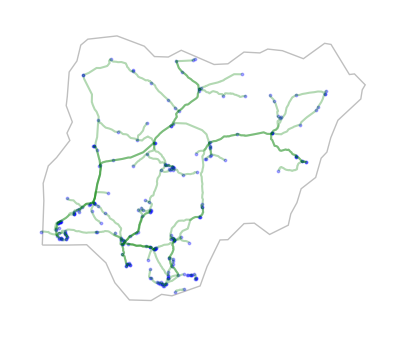

In [4]:
ax = geoplot.polyplot(nigeriaplot, edgecolor="grey", alpha=0.5, figsize=(5, 5)) # Expand figsize for larger image

if option == "line2network":
    lines.plot(figsize=(5, 5), markersize=10, color="green", alpha=0.3, ax=ax)
    substations.plot(figsize=(5, 5), markersize=3, color="blue", alpha=0.3, ax=ax)

else:
    generators.plot(figsize=(5, 5), markersize=10, color="orange", alpha=0.3, ax=ax)
    lines.plot(figsize=(5, 5), markersize=10, color="green", alpha=0.3, ax=ax)
    substations.plot(figsize=(5, 5), markersize=3, color="blue", alpha=0.3, ax=ax)

# Example of how to constrain to one country:
# lines.loc[lines['country'] == 'nigeria'].plot(figsize=(20, 20),markersize=25, color='red',alpha = 0.3, ax=ax)

# #plt.savefig('africa_transmission_and substations_110.png')

# Interactive plot

In [5]:
# Choose the country you want to focus
country = "NG"

In [6]:
if option == "line2network":
    lines_ng = lines[lines["country"] == country]
    substations_ng = substations[substations["country"] == country]

else:
    lines_ng = lines[lines["country"] == country]
    substations_ng = substations[substations["country"] == country]
    generators_ng = generators[generators["Country"] == country]

# Map

In [7]:
# Somehow works with "if" when using display()

if option == "line2network":
    line2network_BL = substations_ng.hvplot( # Buses and Lines
        geo=True,
        size=10,
        frame_height=750,
        alpha=0.4,
        tiles="CartoLight",
        hover_cols=["bus_id"],
        color="orange",
    ) * lines_ng.hvplot(geo=True, alpha=0.4, hover_cols=["line_id"]).opts(
        active_tools=["pan", "wheel_zoom"]
    )
    # display (line2network_BL)     # show plot in the notebook
    hvplot.save(line2network_BL, "documentation/line2network_BL.html") # save plot in the path here

else:
    raw_clean = substations_ng.hvplot(
        geo=True,
        size=10,
        frame_height=750,
        alpha=0.4,
        tiles="CartoLight",
        hover_cols=["bus_id"],
        color="orange",
    ) * lines_ng.hvplot(
        geo=True, alpha=0.4, hover_cols=["line_id"]
    ) * generators_ng.hvplot(
        geo=True, alpha=0.4, color="green"
    ).opts(
        active_tools=["pan", "wheel_zoom"]
    )
    # display (raw_clean)     # show plot in the notebook
    hvplot.save(raw_clean, "documentation/raw_clean.html") # save plot in the path here

In [8]:
# With transformers
line2network_BLT = substations_ng.hvplot( # Buses, Lines and Transformers
    geo=True,
    size=10,
    frame_height=750,
    alpha=0.4,
    tiles="CartoLight",
    hover_cols=["bus_id"],
    color="orange",
) * lines_ng.hvplot(geo=True, alpha=0.4, hover_cols=["line_id"]).opts(
    active_tools=["pan", "wheel_zoom"]
) * transformers.hvplot(
    geo=True, linesize=30, color="red", alpha=0.4, hover_cols=["line_id"]
).opts(
    active_tools=["pan", "wheel_zoom"]
)
# display (line2network_BLT)     # show plot in the notebook
hvplot.save(line2network_BLT, "documentation/line2network_BLT.html") # save plot in the path here